In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Importing Libraries and defining functions

In [ ]:
import numpy as np 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
import matplotlib.pyplot as plt


def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    

    if flag == "train":
        for i in tqdm(training_files):
            try:
                im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
                mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]
                
            except:
                print("This file is corrupted:",i);

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

#perform sanity check
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()


from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Defining paths and getting the file names

In [ ]:
path = "/content/gdrive/My Drive/Lung Segmentation Data"
image_path = os.path.join(path,"CXR_png_new")
mask_path = os.path.join(path,"masks")

# making a 1-1 correspondance from mask to images
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]
#check = [i for i in mask if "mask" in i]
#print("Total mask that has modified name:",len(check))

#jugaad for my dataset
image_to_mask = [fName.split(".png")[0] for fName in images]
check = set(image_file_name) & set(image_to_mask)
check = [i+"_mask" for i in check]
#testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

Loading Data

100%|██████████| 566/566 [00:42<00:00, 12.39it/s]


training set


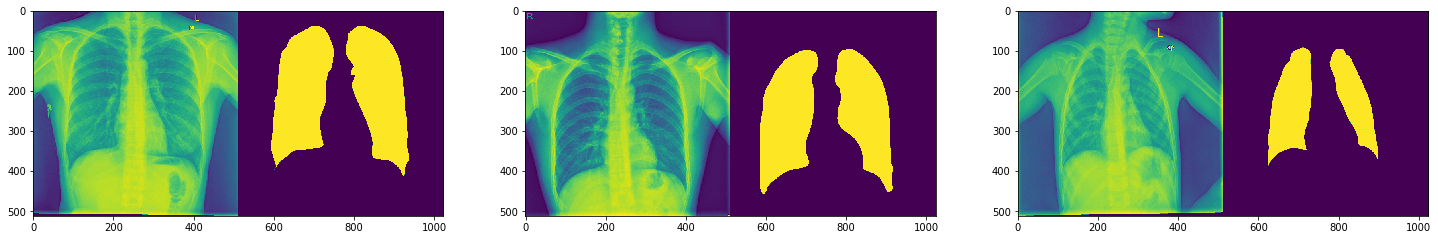

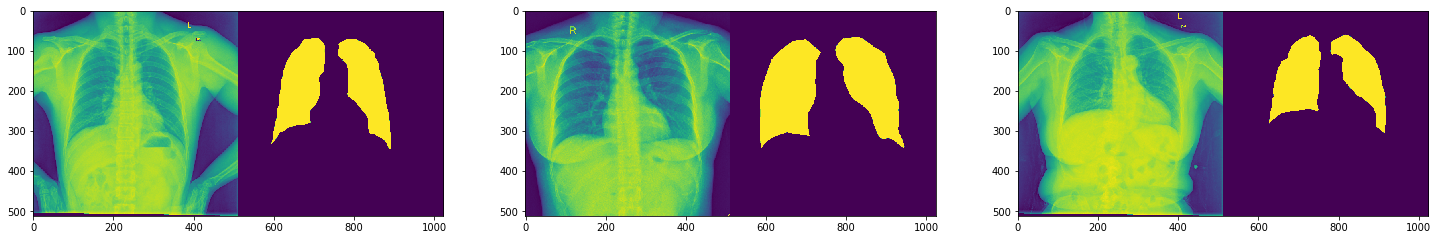

In [ ]:
dim = 256*2
X_train,y_train = getData(dim,flag="train")
#X_test, y_test = getData(dim)

#perform sanity check
print("training set")
plotMask(X_train,y_train)

In [ ]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
assert X_train.shape == y_train.shape
images = X_train
mask  = y_train

In [ ]:
print(X_train.shape)

(566, 512, 512, 1)


Defining and compiling U-net

In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}/{}_model_best_2.hdf5".format(path,'cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Splitting the dataset into training and testing

In [ ]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split



train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

Training the model

In [ ]:
loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Train on 458 samples, validate on 51 samples
Epoch 1/50
458/458 [==============================] - 76s 166ms/step - loss: -0.3520 - dice_coef: 0.3520 - binary_accuracy: 0.7313 - val_loss: -0.4954 - val_dice_coef: 0.4954 - val_binary_accuracy: 0.6582

Epoch 00001: val_loss improved from inf to -0.49537, saving model to /content/gdrive/My Drive/Lung Segmentation Data/cxr_reg_model_best_2.hdf5
Epoch 2/50
458/458 [==============================] - 65s 142ms/step - loss: -0.6942 - dice_coef: 0.6942 - binary_accuracy: 0.8506 - val_loss: -0.8271 - val_dice_coef: 0.8271 - val_binary_accuracy: 0.9095

Epoch 00002: val_loss improved from -0.49537 to -0.82705, saving model to /content/gdrive/My Drive/Lung Segmentation Data/cxr_reg_model_best_2.hdf5
Epoch 3/50
458/458 [==============================] - 65s 141ms/step - loss: -0.8451 - dice_coef: 0.8451 - binary_accuracy: 0.9218 - val_loss: -0.8637 - val_dice_coef: 0.8637 - val_binary_accuracy: 0.9357

Epoch 00003: val_loss improved from -0.82705 t

Doing some plotting

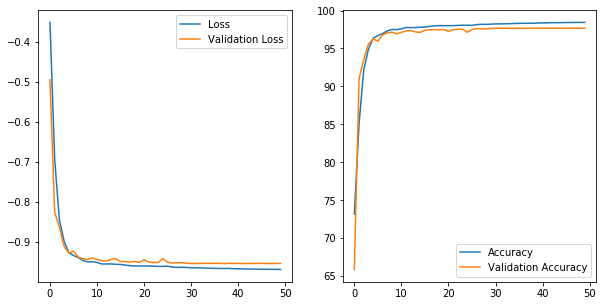

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

Showing results

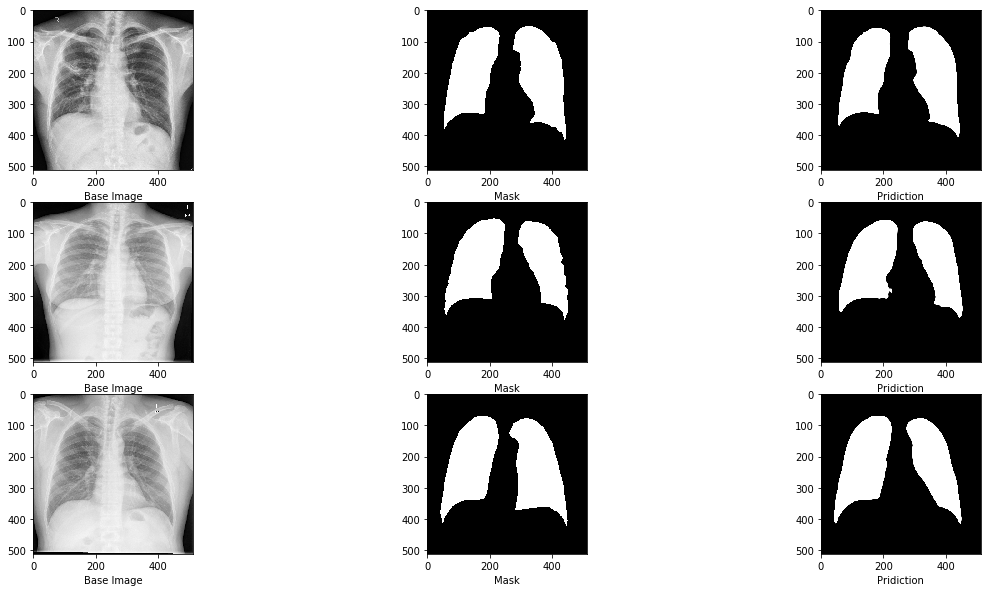

In [ ]:

pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap = 'gray')
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]), cmap = 'gray')
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), cmap = 'gray')
    plt.xlabel("Pridiction")

In [ ]:
predicted_masks = model.predict((images-127.0)/127.0) #(images-127.0)/127.0

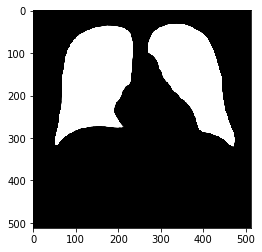

In [ ]:
plt.imshow(np.squeeze(predicted_masks[i]), cmap = 'gray')

In [ ]:
#model.save(path + '/complete_model.h5')
model.save_weights(path + '/complete_weights.h5')

Don't go further down !!!!

In [ ]:
#testFiles = os.listdir(path + '/test/NORMAL')
#testImages = []
#for fileName in testFiles:
#  testImages.append(cv2.resize(cv2.imread(os.path.join(path + '/test/NORMAL',testFiles[0])),(dim,dim))[:,:,0])
#
#testImages2 = np.array(testImages).reshape(len(testImages),dim,dim,1)

ValueError: ignored

In [ ]:
#predicted_mask = model.predict(testImages2)

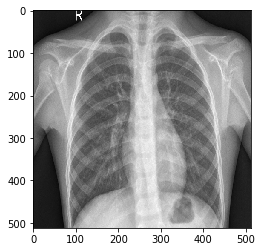

In [ ]:
#plt.imshow(np.squeeze(testImages2[0]), cmap = 'gray')